# Use-case: Exploring genetic interation manifolds

This tutorial shows how to perform the analysis we present in Figure 2 of the [pertpy preprint](https://www.biorxiv.org/content/10.1101/2024.08.04.606516v1). Pertpy can be used to explore genetic interaction manifolds. In this use-case, we will use pertpy's Mixscape implementation to remove confounding effects in the data, and to identify and classify perturbed cells. We will then use the identified perturbed cells to compute a perturbation space and explore the genetic interaction manifolds. This use-case uses the data presented by [Norman et al. (2019)](https://www.science.org/doi/10.1126/science.aax4438).

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pertpy as pt
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Load and preprocess data

In [2]:
adata = pt.dt.norman_2019()
adata

AnnData object with n_obs × n_vars = 111255 × 19018
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', '

In [3]:
adata.obs["perturbed"] = np.where(
    adata.obs["perturbation_name"] == "control", "control", "perturbed"
)

Later, we want to apply Mixscape to remove confounding effects such as the cell-cycle phase. To do this, we need to identify the cell-cycle phase of each cell. We can use the `score_genes_cell_cycle` function from Scanpy to do this:

In [4]:
# Cell cycle genes identified by Tirosh et al., 2016
s_genes = ["MCM5", "PCNA", "TYMS", "FEN1", "MCM2", "MCM4", "RRM1", "UNG", "GINS2", "MCM6", "CDCA7", "DTL", "PRIM1", "UHRF1", "HELLS",
           "RFC2", "RPA2", "NASP", "RAD51AP1", "GMNN", "WDR76", "SLBP", "CCNE2", "UBR7", "POLD3", "MSH2", "ATAD2", "RAD51", "RRM2",
           "CDC45", "CDC6", "EXO1", "TIPIN", "DSCC1", "BLM", "CASP8AP2", "USP1", "CLSPN", "POLA1", "CHAF1B", "BRIP1", "E2F8"]

g2m_genes = ["HMGB2", "CDK1", "NUSAP1", "UBE2C", "BIRC5", "TPX2", "TOP2A", "NDC80", "CKS2", "NUF2", "CKS1B", "MKI67", "TMPO", "CENPF",
             "TACC3", "FAM64A", "SMC4", "CCNB2", "CKAP2L", "CKAP2", "AURKB", "BUB1", "KIF11", "ANP32E", "TUBB4B", "GTSE1", "KIF20B",
             "HJURP", "CDCA3", "HN1", "CDC20", "TTK", "CDC25C", "KIF2C", "RANGAP1", "NCAPD2", "DLGAP5", "CDCA2", "CDCA8", "ECT2",
             "KIF23", "HMMR", "AURKA", "PSRC1", "ANLN", "LBR", "CKAP5", "CENPE", "CTCF", "NEK2", "G2E3", "GAS2L3", "CBX5", "CENPA"]

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

Next, we do some standard preprocessing steps: Log-normalization, highly variable gene selection, PCA, and UMAP embedding.

In [5]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, subset=True, n_top_genes=4000)

In [6]:
sc.pp.neighbors(adata)
sc.pp.pca(adata)
sc.tl.umap(adata)

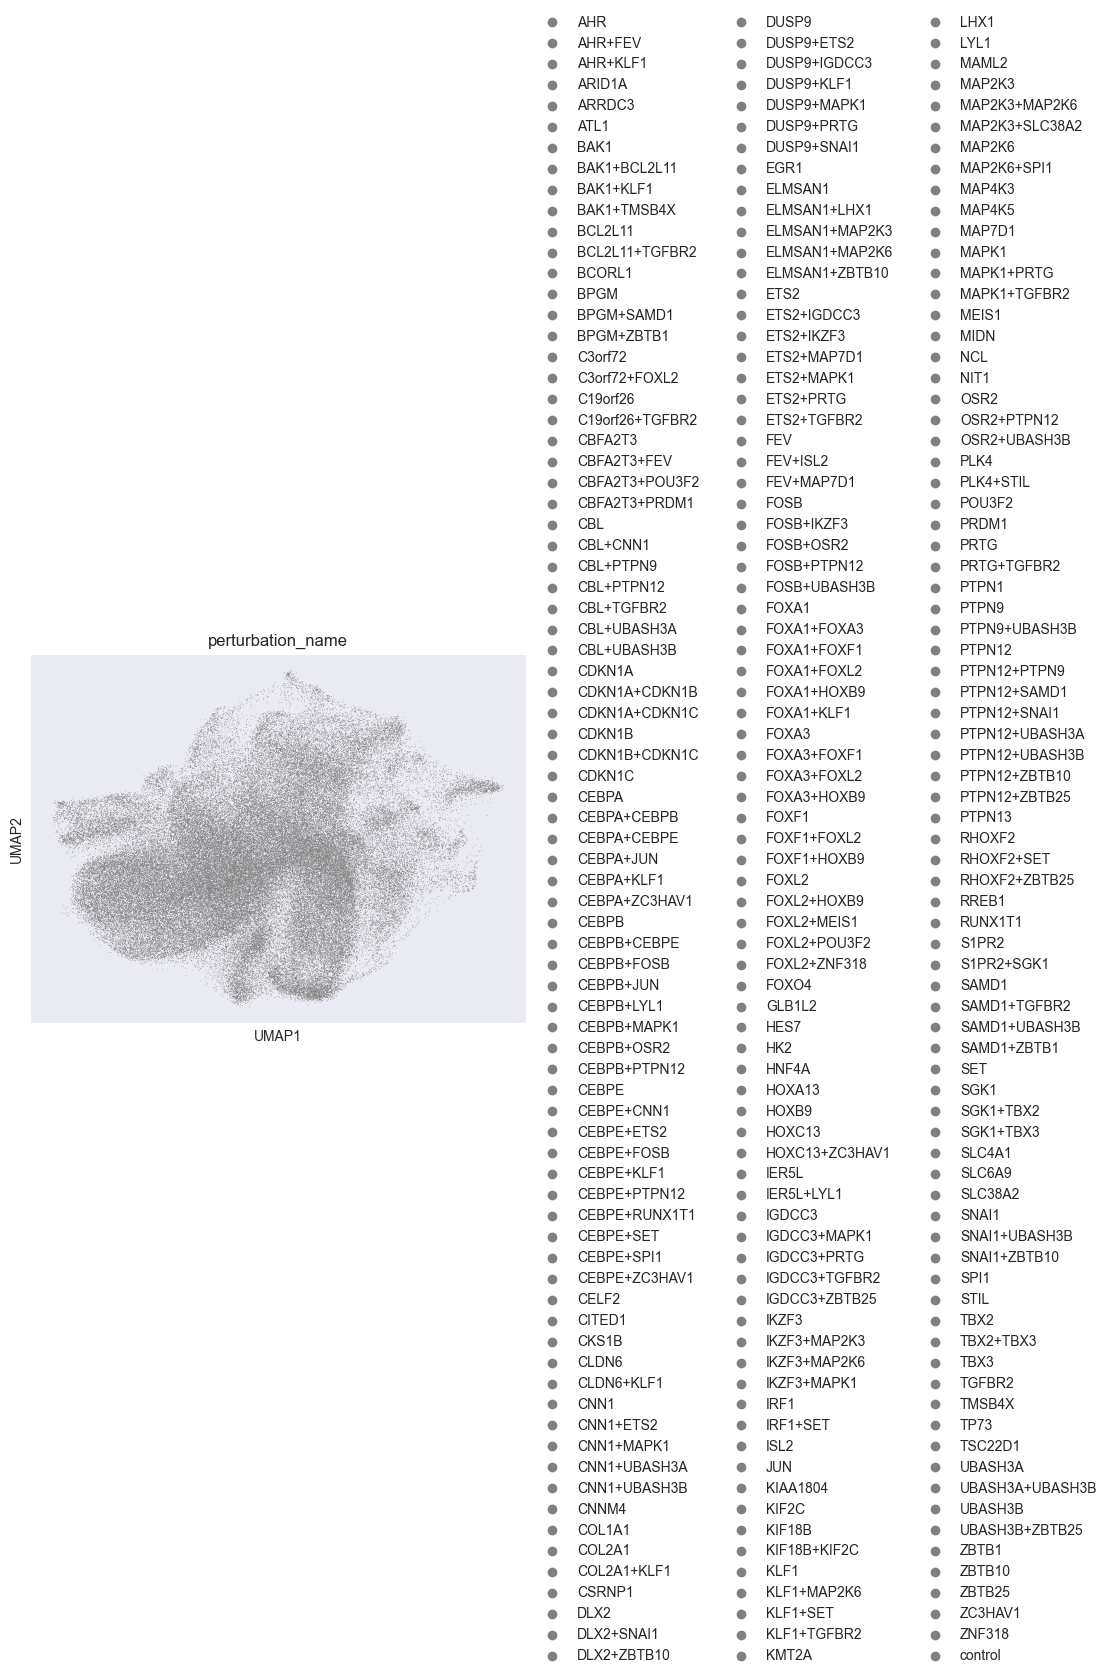

In [7]:
sc.pl.umap(adata, color="perturbation_name")

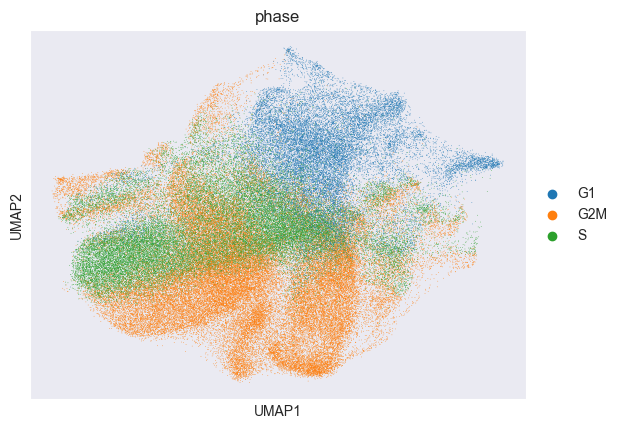

In [8]:
sc.pl.umap(adata, color="phase")

Above, we visualized the computed cell-cycle phase of each cell. We can see that the cell-cycle phase is a confounding factor in the data. We will use Mixscape to remove this confounding effect.

## Apply Mixscape to identify and classify perturbed cells

We start by calculating each cell's perturbation signature using Mixscape. This generates a new layer in the adata object called `X_pert`, which contains the corrected data.

In [9]:
ms_pt = pt.tl.Mixscape()
ms_pt.perturbation_signature(adata, pert_key="perturbation_name", control="control")

In [10]:
adata_pert = adata.copy()
adata_pert.X = adata_pert.layers["X_pert"]
adata_pert

AnnData object with n_obs × n_vars = 111255 × 4000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'g

Let's compute the PCA and UMAP of the data corrected for confounding effects by Mixscape:

In [11]:
sc.pp.pca(adata_pert)
sc.pp.neighbors(adata_pert, metric="cosine")
sc.tl.umap(adata_pert)

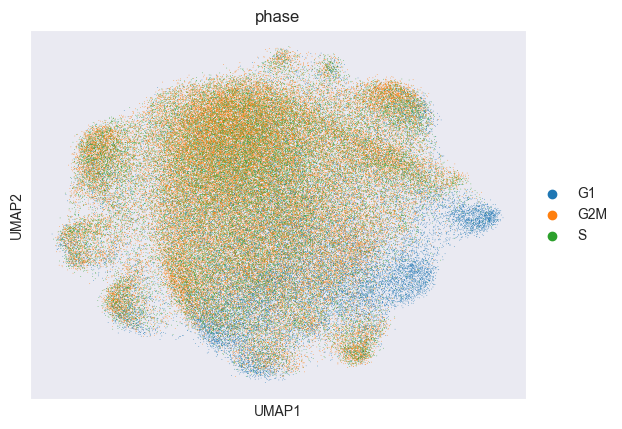

In [12]:
sc.pl.umap(adata_pert, color="phase")

Next, we identify and remove cells that have "escaped" the CRISPR perturbation:

In [13]:
adata.obs["guide_ids"] = adata.obs["guide_ids"].cat.rename_categories({"": "control"})
ms_pt.mixscape(adata=adata, control="control", labels="guide_ids", layer="X_pert")

We can visualize the perturbation score calculated and the cell classification computed based on that for an individual perturbation, here for the perturbations targeting the genes IGDCC3 and TGFBR2:

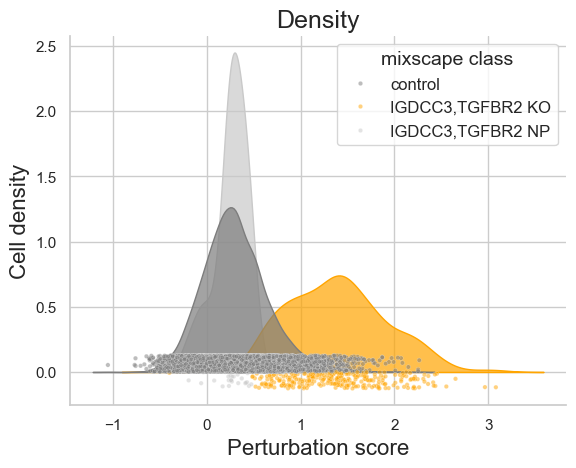

In [14]:
ms_pt.plot_perturbscore(
    adata=adata,
    labels="guide_ids",
    target_gene="IGDCC3,TGFBR2",
)

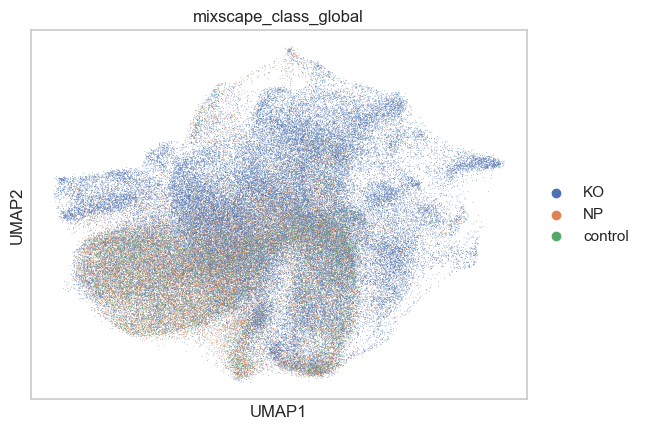

In [15]:
sc.pl.umap(adata, color=["mixscape_class_global"])

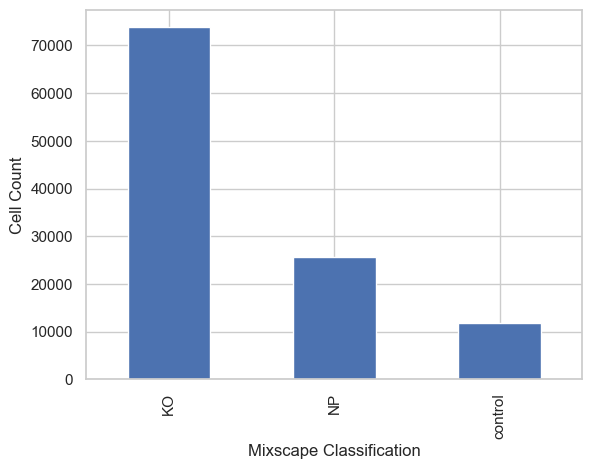

In [16]:
classification_counts = adata.obs["mixscape_class_global"].value_counts()
classification_counts.plot(kind="bar")
plt.xlabel("Mixscape Classification")
plt.ylabel("Cell Count")
plt.show()

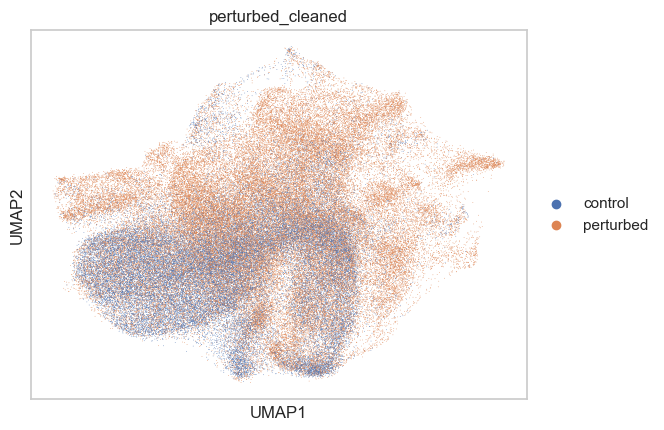

In [17]:
adata.obs["perturbed_cleaned"] = adata.obs.apply(
    lambda row: (
        "control" if row["mixscape_class_global"] == "NP" else row["perturbed"]
    ),
    axis=1,
).astype("category")

sc.pl.umap(adata, color=["perturbed_cleaned"])

In [18]:
pre_silhouette = silhouette_score(adata.obsm["X_umap"], adata.obs["perturbed"])
print("Pre-Mixscape Silhouette Score:", pre_silhouette)

post_silhouette = silhouette_score(
    adata_pert.obsm["X_umap"], adata.obs["perturbed_cleaned"]
)
print("Post-Mixscape Silhouette Score:", post_silhouette)

Pre-Mixscape Silhouette Score: -0.026800336
Post-Mixscape Silhouette Score: 0.049118705


We can see that applying Mixscape has sucessfully improved the silhouette score.

## Computing and exploring the perturbation space

We can now use the identified perturbed cells to compute a perturbation space and explore the genetic interaction manifolds. We will use the MLPClassifierSpace to compute the perturbation embeddings and the PseudobulkSpace to compute the pseudobulk embeddings. Furthermore, we will use the gene programme annotations provided by [Norman et al. (2019)](https://www.science.org/doi/10.1126/science.aax4438) to label the cells. Based on the perturbation space, we will then use label transfer to expand the gene programme annotations to cells with "Unknown" gene programme.

In [19]:
# Gene programme annotations from Norman et al., 2019

G1_CYCLE = [
    "CDKN1A",
    {"CDKN1B", "CDKN1A"},
    "CDKN1B",
    {"CDKN1C", "CDKN1A"},
    {"CDKN1C", "CDKN1B"},
    "CDKN1C",
]

ERYTHROID = [
    {"CBL", "CNN1"},
    {"CBL", "PTPN12"},
    {"CBL", "PTPN9"},
    {"CBL", "UBASH3B"},
    {"SAMD1", "PTPN12"},
    {"SAMD1", "UBASH3B"},
    {"UBASH3B", "CNN1"},
    {"UBASH3B", "PTPN12"},
    {"UBASH3B", "PTPN9"},
    {"UBASH3B", "UBASH3A"},
    {"UBASH3B", "ZBTB25"},
    {"BPGM", "SAMD1"},
    "PTPN1",
    {"PTPN12", "PTPN9"},
    {"PTPN12", "UBASH3A"},
    {"PTPN12", "ZBTB25"},
    {"UBASH3A", "CNN1"},
]

PIONEER_FACTORS = [
    {"FOXA1", "FOXF1"},
    {"FOXA1", "FOXL2"},
    {"FOXA1", "HOXB9"},
    {"FOXA3", "FOXA1"},
    {"FOXA3", "FOXF1"},
    {"FOXA3", "FOXL2"},
    {"FOXA3", "HOXB9"},
    "FOXA3",
    {"FOXF1", "FOXL2"},
    {"FOXF1", "HOXB9"},
    {"FOXL2", "MEIS1"},
    "HOXA13",
    "HOXC13",
    {"POU3F2", "FOXL2"},
    "TP73",
    "MIDN",
    {"LYL1", "IER5L"},
    "HOXC13",
    {"DUSP9", "SNAI1"},
    {"ZBTB10", "SNAI1"},
]

GRANULOCYTE_APOPTOSIS = [
    "SPI1",
    "CEBPA",
    {"CEBPB", "CEBPA"},
    "CEBPB",
    {"CEBPE", "CEBPA"},
    {"CEBPE", "CEBPB"},
    {"CEBPE", "RUNX1T1"},
    {"CEBPE", "SPI1"},
    "CEBPE",
    {"ETS2", "CEBPE"},
    {"KLF1", "CEBPA"},
    {"FOSB", "CEBPB"},
    {"FOSB", "CEBPE"},
    {"ZC3HAV1", "CEBPA"},
    {"JUN", "CEBPA"},
]

PRO_GROWTH = [
    {"CEBPE", "KLF1"},
    "KLF1",
    {"KLF1", "BAK1"},
    {"KLF1", "MAP2K6"},
    {"KLF1", "TGFBR2"},
    "ELMSAN1",
    {"MAP2K3", "SLC38A2"},
    {"MAP2K3", "ELMSAN1"},
    "MAP2K3",
    {"MAP2K3", "MAP2K6"},
    {"MAP2K6", "ELMSAN1"},
    "MAP2K6",
    {"MAP2K6", "KLF1"},
]

MEGAKARYOCYTE = [
    {"MAPK1", "TGFBR2"},
    "MAPK1",
    {"ETS2", "MAPK1"},
    "ETS2",
    {"CEBPB", "MAPK1"},
]

programmes = {
    "G1 cell cycle": G1_CYCLE,
    "Erythroid": ERYTHROID,
    "Pioneer factors": PIONEER_FACTORS,
    "Granulocyte apoptosis": GRANULOCYTE_APOPTOSIS,
    "Pro-growth": PRO_GROWTH,
    "Megakaryocyte": MEGAKARYOCYTE,
}

In [20]:
gene_programme = []

for target_pert in adata.obs["perturbation_name"]:
    if target_pert == "control":
        gene_programme.append("Control")
        continue

    found_programme = False
    for programme, pert_list in programmes.items():
        for pert in pert_list:
            if (type(pert) == set and pert == set(target_pert.split("+"))) or (
                target_pert == pert
            ):
                gene_programme.append(programme)
                found_programme = True
                break

    if not found_programme:
        gene_programme.append("Unknown")

adata.obs["gene_programme"] = gene_programme
adata.obs["gene_programme"] = adata.obs["gene_programme"].astype("category")

Next, we remove the cells classified as "NP" by Mixscape, i.e. the cells that have "escaped" the perturbation. This is done to ensure that the computed perturbation space is not confounded by these cells. We will then train the MLPClassifierSpace on the remaining cells. The MLP is trained to distinguish between the different perturbations, thereby learning representations that capture perturbation-specific effects. The MLPClassifierSpace computes the perturbation embeddings based on the trained MLP, i.e. one embedding per cell. Based on the embeddings, we can compute the pseudobulk embeddings using the PseudobulkSpace. The pseudobulk embeddings represent the average perturbation effect for each perturbation.

In [21]:
adata_mixscape_cleaned = adata[adata.obs["mixscape_class_global"] != "NP"]
adata_mixscape_cleaned

View of AnnData object with n_obs × n_vars = 85648 × 4000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF

In [ ]:
ps = pt.tl.MLPClassifierSpace()

pert_embeddings = ps.compute(
    adata_mixscape_cleaned,
    target_col="perturbation_name",
    hidden_dim=[512, 256],
    dropout=0.05,
    batch_size=64,
    batch_norm=True,
    max_epochs=5,
)

In [23]:
pert_embeddings

AnnData object with n_obs × n_vars = 85648 × 256
    obs: 'perturbations', 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'g

In [24]:
ps = pt.tl.PseudobulkSpace()
psadata_classifier = ps.compute(
    pert_embeddings,
    target_col="perturbations",
    groups_col="perturbations",
    mode="mean",
    min_cells=0,
    min_counts=0,
)

In [25]:
psadata_classifier

AnnData object with n_obs × n_vars = 237 × 256
    obs: 'perturbations', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'guide_KLF1', 'guide_KMT2A', 'guide_LHX1', 'guide_LYL1', 'guide_MAML2', 'guide_MAP2K3', 'guide

Let's visualize the perturbation space that we computed using the MLPClassifierSpace and the PseudobulkSpace:

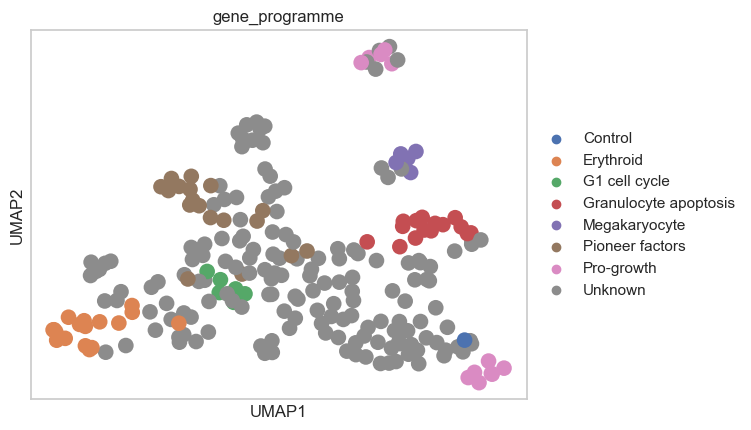

In [27]:
sc.pp.neighbors(psadata_classifier, use_rep="X")
sc.tl.umap(psadata_classifier)
sc.pl.umap(psadata_classifier, color="gene_programme")

Based on the computed perturbation space, we can use label transfer to expand the gene programme annotations to cells with "Unknown" gene programme. This must be done carefully, especially by considering the number of neighbors used for label transfer. We do not want to transfer the labels to cells that are too far away in the perturbation space, as this could lead to incorrect labels. Here, we will use 10 neighbors for label transfer:

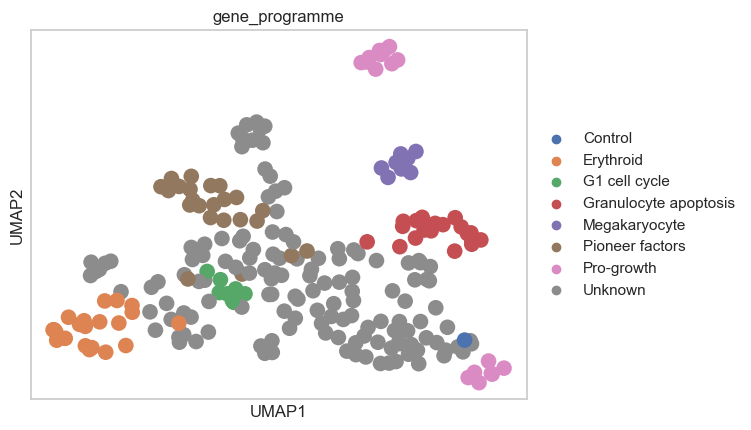

In [28]:
ps.label_transfer(psadata_classifier, column="gene_programme", target_val="Unknown", n_neighbors=10)
sc.pl.umap(psadata_classifier, color="gene_programme")